This script reproduces the Working Experiment section for the paper's cersion submitted to NeurIPS's AFCP2022 workshop. Please insure that you have all packages installed for running this script. We use Figure 1 from [Karimi et al. (2020)](https://arxiv.org/pdf/2002.06278.pdf) as the baseline data generating model (DGM), which we modify by introducing gender as $A$.

In [1]:
import random
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

# general settings  
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=11)
plt.rc('legend', fontsize=11)
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('axes', edgecolor='k')
plt.rc('xtick.major', width=2)
plt.rc('xtick.major', size=6)
plt.rc('ytick.major', width=2)
plt.rc('ytick.major', size=6)
plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

### Get the (factual) dataset $\mathcal{D}$

In [2]:
# change data path accordingly
data_path = os.getcwd() + '\\' + 'data' + '\\'
org_df = pd.read_csv(data_path + '\\' + 'Karimi2020_v2.csv', sep='|', )

In [3]:
# np.random.seed(2020)

# n = 5000

# # let A be Gender, where A=1 represents female
# p_men = 0.65
# uA = random.choices(population=[0, 1], weights=[p_men, (1 - p_men)], k=n)
# A = np.asanyarray(uA) 
# bias_a1 = (-1500)*np.random.poisson(lam=10, size=n)
# bias_a2 = (-300)*np.random.chisquare(df=4, size=n)

# # other hyperparams
# lambda_1 = 10000
# lambda_2 = 2500
# beta_1 = (3/10)
# beta_2 = 5
# u1 = lambda_1*np.random.poisson(lam=10, size=n)
# u2 = lambda_2*np.random.normal(loc=0.0, scale=1.0, size=n)

# # X1: annual salary
# n_x1 = u1 + A*bias_a1
# # X2: account balance
# n_x2 = beta_1*n_x1 + u2 + A*bias_a2

# # Y: loan approval
# n_y = np.sign(n_x1 + beta_2*n_x2 - 225000)

# # get orginal df
# n_d = {'LoanApproval': n_y, 
#        'AnnualSalary': n_x1, 
#        'AccountBalance': n_x2,
#        'u1': u1,
#        'u2': u2,
#        'Gender': A}
# org_df = pd.DataFrame(n_d)

# org_df.head(5)

### Generate the counterfactual dataset $\mathcal{D}^{DF}$

In [4]:
# define the list of features
feat_trgt = ['LoanApproval']
feat_rlvt = ['AnnualSalary', 'AccountBalance']
feat_prot = ['Gender']
do = {'Gender': 0} # female to male
df = org_df[feat_trgt + feat_rlvt + feat_prot].copy()

In [5]:
df.head(5)

,LoanApproval,AnnualSalary,AccountBalance,Gender
0,-1.0,35000,7947.678090,1
1,1.0,120000,36940.097383,0
2,-1.0,90000,23564.129008,0
3,-1.0,80000,27596.570524,0
4,1.0,201000,59008.567839,1


In [6]:
# store counterfactual df
cf_df = dict()

In [7]:
# 1) estimate each f in M where needed according to the known causal graph:

# 1.1) create model objects
# f for AnnualSalary
model_sal = LinearRegression(fit_intercept=True, normalize=False)
# f for AccountBalance
model_acc = LinearRegression(fit_intercept=True, normalize=False)

# 1.2) prepare data for the models
# f for Salary
x_sal = np.array(df['Gender'].copy()).reshape((-1, 1))
y_sal = np.array(df['AnnualSalary'].copy())
# f for Account
x_acc = np.array(df[['AnnualSalary', 'Gender']].copy())#.reshape((-1, 1))
y_acc = np.array(df['AccountBalance'].copy())

# 1.3) estimate the models
model_sal.fit(x_sal, y_sal)
model_acc.fit(x_acc, y_acc)

LinearRegression()

In [8]:
# 2) generate the (structural) counterfactuals (cf) for X using Pearl's abduction, action, prediction steps:

# 2.1) Abduction (or individual error terms given each f)
cf_df['u_AnnualSalary'] = round(df['AnnualSalary'] - model_sal.predict(x_sal), 2)
cf_df['u_AccountBalance'] = round(df['AccountBalance'] - model_acc.predict(x_acc), 2)
cf_df = pd.DataFrame.from_dict(cf_df)

# 2.2) Action + Prediction (X-wise): here, we focus on being female (the protected group)
do_male = np.repeat(0, repeats=df.shape[0]).reshape((-1, 1))
cf_df['AnnualSalary'] = round(model_sal.predict(do_male) + cf_df['u_AnnualSalary'], 2)
do_male2 = cf_df[['AnnualSalary']].copy()
do_male2['Gender'] = do_male
cf_df['AccountBalance'] = round(model_acc.predict(do_male2) + cf_df['u_AccountBalance'], 2)

In [9]:
# 3) Prediction (Y-wise): Generate cf_Y (when b is known)

# b params
beta_0 = 225000
beta_1 = (3/10)
beta_2 = 5
# b functional form
cf_df['LoanApproval'] = np.sign(cf_df['AnnualSalary'] + beta_2*cf_df['AccountBalance'] - beta_0)

# keep track of A (i.e., original gender)
cf_df['Gender'] = df['Gender']
# lose the U's
cf_df = cf_df[feat_trgt + feat_rlvt + feat_prot]

In [10]:
cf_df.head(5)

,LoanApproval,AnnualSalary,AccountBalance,Gender
0,-1.0,50796.35,13852.05,1
1,1.0,120000.00,36940.10,0
2,-1.0,90000.00,23564.13,0
3,-1.0,80000.00,27596.57,0
4,1.0,216796.35,64912.94,1


In [22]:
max(cf_df[cf_df['Gender']==1]['AnnualSalary'])

216796.35

Text(0.5, 0, 'Annual salary ($X1$) for females')

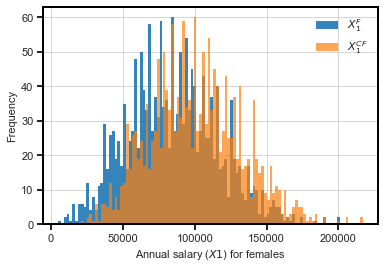

In [39]:
# distributions for paper: X1
b = 100
plt.hist(df[df['Gender']==1]['AnnualSalary'], bins = b, alpha=0.9, label=r'$X_1^F$')
plt.hist(cf_df[cf_df['Gender']==1]['AnnualSalary'], bins = b, alpha=0.7, label=r'$X_1^{CF}$')
plt.legend(loc='upper right')

#plt.title('Annual salary for females')
plt.ylabel('Frequency')
plt.xlabel(r'Annual salary ($X1$) for females')

Text(0.5, 0, 'Account balance ($X_2$) for females')

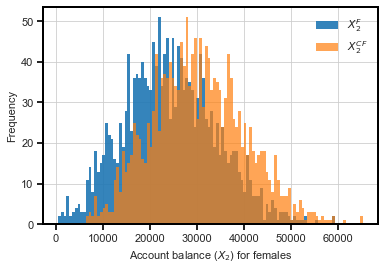

In [38]:
# distributions for paper: X2
b = 100
plt.hist(df[df['Gender']==1]['AccountBalance'], bins=b, alpha=0.9, label=r'$X_2^F$')
plt.hist(cf_df[cf_df['Gender']==1]['AccountBalance'], bins=b, alpha=0.7, label=r'$X_2^{CF}$')
plt.legend(loc='upper right')

#plt.title(r'Account balance for females')
plt.ylabel('Frequency')
plt.xlabel(r'Account balance ($X_2$) for females')

### Run cfST

In [11]:
# load functions locally
from src.cf_situation_testing import get_k_neighbors, get_wald_ci

In [21]:
# cfST parameters:

# target feature
feat_trgt = 'LoanApproval'
# values for the target feature: use 'pos' and 'neg' accordingly
feat_trgt_vals = {'pos': 1, 'neg': -1}
# list of relevant features
feat_rlvt = ['AnnualSalary', 'AccountBalance']
# protected feature
feat_prot = 'Gender'
# values for the protected feature: use 'non_protected' and 'protected' accordingly
feat_prot_vals = {'non_protected': 0, 'protected': 1}

# size of neiuborhoods
n = 15
# distance function
d = 'manhattan'
# weighted k-NN?
weights = None # else, e.g., weights = {'AnnualSalary': 5, 'AccountBalance': 1}
# standardize features?
standardize = True
# significance level (over 100)
alpha = 0.05
# tau diviation
tau = 0.0

In [22]:
# # total factual datset size
# df.shape[0]
# # total counterfactual datset size
# cf_df.shape[0]

# number of eligible complainants:
df[df['Gender'] == 1].shape[0]

1712

In [23]:
# get control and test neighborhoods 
dict_df_neighbors = get_k_neighbors(df=df, cf_df=cf_df, k=n, 
                                    feat_trgt=feat_trgt, feat_trgt_vals=feat_trgt_vals, 
                                    feat_rlvt=feat_rlvt, 
                                    feat_prot=feat_prot, feat_prot_vals=feat_prot_vals, 
                                    standardize=standardize,
                                    weights=weights
                                   )
print('done')

target feature LoanApproval with values {'pos': 1, 'neg': -1}
protected feature Gender with values {'non_protected': 0, 'protected': 1}
with relevant features ['AnnualSalary', 'AccountBalance']
all features: ['LoanApproval', 'AnnualSalary', 'AccountBalance', 'Gender']
===> standardizing
done


In [14]:
# each item is an eligible complainant and has a 'control' and 'test' groups as dataframes: from df, tuple 0 is female 
# dict_df_neighbors[0]

In [24]:
# prove discrimination via Wald CIs
test_disc = get_wald_ci(dict_df_neighbors=dict_df_neighbors,
                        feat_trgt=feat_trgt, feat_trgt_vals=feat_trgt_vals,
                        alpha=alpha,
                        tau=tau
                       )
print('done')

using significance level of 5.0%
using tau-deviation of 0.0
done


In [25]:
# column cfST indicates the discrimination output:
test_disc.head(5)

,individual,p1,p2,org_diff,d_alpha,diff,CIs,cfST
0,0,1.0000,1.0,0.000,0.00000,0.0,"[0.0, 0.0]",No
1,4,0.0000,0.0,0.000,0.00000,0.0,"[0.0, 0.0]",No
2,5,0.0625,0.0,0.062,0.11861,0.0,"[-0.05611011497760214, 0.18111011497760215]",Yes
3,6,1.0000,1.0,0.000,0.00000,0.0,"[0.0, 0.0]",No
4,9,1.0000,0.0,1.000,0.00000,1.0,"[1.0, 1.0]",Yes


In [26]:
# number of discriminated inds:
test_disc[test_disc['cfST'] == 'Yes'].shape[0]

440

In [33]:
# results for Table 1
for new_k in [15, 30, 50, 100]:
    
    temp_dict_df_neighbors = get_k_neighbors(df=df, cf_df=cf_df, 
                                             k=new_k, 
                                             feat_trgt=feat_trgt, feat_trgt_vals=feat_trgt_vals, 
                                             feat_rlvt=feat_rlvt, 
                                             feat_prot=feat_prot, feat_prot_vals=feat_prot_vals, 
                                             standardize=standardize,
                                             weights=weights
                                            )
    print('done 1')
    temp_test_disc = get_wald_ci(dict_df_neighbors=temp_dict_df_neighbors,
                                 feat_trgt=feat_trgt, feat_trgt_vals=feat_trgt_vals,
                                 alpha=alpha,
                                 tau=tau
                                )
    print('done 2')
    
    print(f"k = {new_k}")
    print(f"number of discrimination cases = {temp_test_disc[temp_test_disc['cfST'] == 'Yes'].shape[0]}")
#     print(f"in perc = {temp_test_disc[temp_test_disc['cfST'] == 'Yes'].shape[0] / df.shape[0] * 100}")
    print(f"in perc = {temp_test_disc[temp_test_disc['cfST'] == 'Yes'].shape[0] / temp_test_disc.shape[0] * 100}")
    
    del temp_dict_df_neighbors, temp_test_disc

print('done')

target feature LoanApproval with values {'pos': 1, 'neg': -1}
protected feature Gender with values {'non_protected': 0, 'protected': 1}
with relevant features ['AnnualSalary', 'AccountBalance']
all features: ['LoanApproval', 'AnnualSalary', 'AccountBalance', 'Gender']
===> standardizing
done 1
using significance level of 5.0%
using tau-deviation of 0.0
done 2
k = 15
number of discrimination cases = 440
in perc = 25.70093457943925
target feature LoanApproval with values {'pos': 1, 'neg': -1}
protected feature Gender with values {'non_protected': 0, 'protected': 1}
with relevant features ['AnnualSalary', 'AccountBalance']
all features: ['LoanApproval', 'AnnualSalary', 'AccountBalance', 'Gender']
===> standardizing
done 1
using significance level of 5.0%
using tau-deviation of 0.0
done 2
k = 30
number of discrimination cases = 461
in perc = 26.92757009345794
target feature LoanApproval with values {'pos': 1, 'neg': -1}
protected feature Gender with values {'non_protected': 0, 'protected':

### Run k-NN ST

In [48]:
# load functions locally
import src.dd as dd

In [50]:
# reload factual data (no need to use the counterfactuals)
df = pd.read_csv(data_path + 'Karimi2020_v2.csv', sep='|', )
del df['u1']
del df['u2']
# for 'convinience' make 'Gender' var explicit
df['Gender'] = df['Gender'].map({0: 'Male', 1: 'Female'})

In [51]:
# nominal-ordinal-continuous partition of predictive attributes (required for distance functions)
nominal_atts = ['Gender']
ordinal_atts = []
continuous_atts = ['AnnualSalary', 'AccountBalance']

# encoding of ordinal attributes as integers plus (optional) encoding of nominal/target attributes
decode = {
    'Gender': {0: 'Male', 1: 'Female'},
    'LoanApproval': {0: -1.0, 1: 1.0}
    }

# predictive attributes (for models)
target = 'LoanApproval'
pred_atts = nominal_atts + ordinal_atts + continuous_atts
print(pred_atts)
pred_all = pred_atts + [target]
print(pred_all)

# protected/unprotected groups attribute
sensitive_att = 'Gender'

['Gender', 'AnnualSalary', 'AccountBalance']
['Gender', 'AnnualSalary', 'AccountBalance', 'LoanApproval']


In [52]:
# encode nominal, ordinal, and target attribute
df_code = dd.Encode(nominal_atts + ordinal_atts + [target], decode)
df = df_code.fit_transform(df)
# set ordinal type as int (instead of category)
df[ordinal_atts] = df[ordinal_atts].astype(int)

df.head(5)

,Gender,LoanApproval,AccountBalance,AnnualSalary
0,1,0,7947.678090,35000
1,0,1,36940.097383,120000
2,0,0,23564.129008,90000
3,0,0,27596.570524,80000
4,1,1,59008.567839,201000


In [53]:
# dictionary of encodings for each discrete column
df_code.decode

{'Gender': {0: 'Male', 1: 'Female'}, 'LoanApproval': {0: -1.0, 1: 1.0}}

In [54]:
# create new df for storing k-nn ST
df2 = df.copy()

In [56]:
# number of neighbors
k = 15

# object for indvidual discrimination analysis
dist = dd.ID(df, nominal_atts, continuous_atts, ordinal_atts)

# protected attribute
pro_att = 'Gender'
unpro_val = df_code.encode['Gender']['Male']

unpro_train = df2[sensitive_att]==unpro_val
pro_train = df2[sensitive_att]!=unpro_val

In [58]:
# sets risk difference for target based on top-k neighbor instances
df2['t'] = dist.topkdiff(df2, # dataframe
                         unpro_train,      # unprotected
                         pro_train,        # protected (could be a list)
                         target+'=0',      # bad decision
                         dist.kdd2011dist, # distance
                         k)                # k-neighbors
print('done')

done


In [61]:
# column 't' is p1 - p2, of the diff
df2.head(5)

,Gender,LoanApproval,AccountBalance,AnnualSalary,t
0,1,0,7947.678090,35000,0.0
1,0,1,36940.097383,120000,0.0
2,0,0,23564.129008,90000,0.0
3,0,0,27596.570524,80000,0.0
4,1,1,59008.567839,201000,0.0


In [64]:
tau = 0.0
print(df2[df2['t'] > tau].shape[0])

55


In [65]:
df3 = df.copy()

for new_k in [15, 30, 50, 100]:
    
    temp_df = df3.copy()
    
    temp_df['t'] = dist.topkdiff(df3, # dataframe
                                 unpro_train,      # unprotected
                                 pro_train,        # protected (could be a list)
                                 target+'=0',      # bad decision
                                 dist.kdd2011dist, # distance
                                 new_k)                # k-neighbors
    
    print(f"k = {new_k}")
    print(f"number of discrimination cases = {temp_df[temp_df['t'] > tau].shape[0]}")
#     print(f"in perc = {temp_test_disc[temp_test_disc['cfST'] == 'Yes'].shape[0] / df.shape[0] * 100}")
    print(f"in perc = {temp_df[temp_df['t'] > tau].shape[0] / temp_df[temp_df['Gender']==1].shape[0] * 100}")
    
    del temp_df

print('done')

k = 15
number of discrimination cases = 55
in perc = 3.212616822429906
k = 30
number of discrimination cases = 65
in perc = 3.7967289719626165
k = 50
number of discrimination cases = 84
in perc = 4.906542056074766
k = 100
number of discrimination cases = 107
in perc = 6.25
done
